# Hypothetical molecule pool characterization
- Analyze chemical space of hypothetical molecules.
- Note that this notebook starts by reading 235 files of hypothetical molecule data. 

In [24]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import glob
import sys
from collections import Counter
from rdkit import Chem 
from rdkit.Chem import AllChem
from matplotlib.colors import LogNorm
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from zeobind.src.utils.utils import setup_mpl
setup_mpl() 
import warnings
warnings.filterwarnings("ignore")

# Plotting functions 

In [7]:
cm = 1/2.54  # centimeters in inches

def plot_mols(ss, legend, n_cols=5, img_size=(200, 200)):
    # Convert SMILES strings to RDKit molecule objects
    mols = [Chem.MolFromSmiles(s) for s in ss]

    # Define subplot dimensions
    n_mols = len(mols)
    n_cols = n_cols  # Number of columns in the subplot grid
    n_rows = n_mols // n_cols + (n_mols % n_cols > 0)  # Calculate rows needed

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))  # Adjust figure size as needed

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    for i, mol in enumerate(mols):
        # Generate molecule image
        img = Draw.MolToImage(mol, size=img_size)  # Adjust image size as needed
        
        # Plot the image
        axs[i].imshow(img)

        # Hide the spines
        for spine in axs[i].spines.values():
            spine.set_visible(False)

        # Hide all y-axis related elements
        axs[i].get_yaxis().set_visible(False)

        # Set the x-axis label with the molecule label and other metrics
        axs[i].set_xlabel(legend[i], rotation=0, labelpad=2, verticalalignment='center', fontsize=15)

        # Hide x-axis ticks 
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    return fig, axs

    
def show_mols(smis, legend=None, molsperrow=10, maxmols=50, subimgsize=(200, 200)):
    '''Show molecules in a grid.'''
    mols = [Chem.MolFromSmiles(smi) for smi in smis]
    if not legend:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
        )
    else:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
            legends=legend,
        )
    return img

def save_mpl_fig(fig, basename, ending='.pdf', dpi=300):
    fig.savefig(basename + ending, bbox_inches='tight', dpi=dpi)

def get_cb(fig, sc, axs, label, ticks=None, linewidth=2, tickwidth=2, labelsize=18, labelpad=20):
    '''Get colorbar'''
    cb = fig.colorbar(sc, ax=axs)
    cb.set_label(label, fontsize=labelsize)
    cb.outline.set_linewidth(linewidth)
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.ax.tick_params(width=tickwidth)
    cb.ax.tick_params(labelsize=labelsize)
    # pad
    cb.ax.xaxis.labelpad = labelpad
    return cb

def get_legend(
    fig,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=15,
    loc="upper center",
    ncol=2,
    axs=None,
    format_handles=False,
    legend_colors=None,
    linewidth=2,
    edgecolor="k",
    put_where="fig",
):
    '''Get legend.'''
    positions = {"fig": fig, "axs": axs}
    legend = positions[put_where].legend(
        fontsize=fontsize,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncol=ncol,
        frameon=False,
    )

    if format_handles:
        for idx, handle in enumerate(legend.legendHandles):
            handle.set_color(legend_colors[idx])
            handle.set_linewidth(linewidth)
            handle.set_edgecolor(edgecolor)

    return legend
    
def get_color_values(num_colors, c="viridis"):
    '''Get a list of color values from a colormap'''
    cmap = plt.cm.get_cmap(c)
    color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return color_values

def draw_parity(axs, xlimits, ylimits, lw=1):
    '''Draw a parity line on a plot'''
    limits = [min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1])]
    axs.plot(limits, limits, "k--", lw=lw)
    return axs

def format_axs(
    axs,
    xtick_size,
    ytick_size,
    spines_width,
    xlabel,
    ylabel,
    xlabel_size,
    ylabel_size,
    limits=None,
    tick_width=1, 
    tick_size=4, 
    bold_axs=False,
    weight=None,
    xticks=None,
    yticks=None,
):
    
    if bold_axs:
        weight = 'bold'

    # Set tick labels
    if xticks is not None:
        axs.set_xticks(xticks)
    if yticks is not None:
        axs.set_yticks(yticks)

    axs.tick_params(axis="x", which="major", labelsize=xtick_size)
    axs.tick_params(axis="y", which="major", labelsize=ytick_size)
    axs.xaxis.set_tick_params(width=tick_width, size=tick_size)
    axs.yaxis.set_tick_params(width=tick_width, size=tick_size)

    # Bold the tick labels
    axs.set_xticklabels(axs.get_xticks(), fontweight=weight)
    axs.set_yticklabels(axs.get_yticks(), fontweight=weight)
    
    # axs.tick_params(axis='both', which='minor="something", labelsize=8)
    for axis in ["top", "bottom", "left", "right"]:
        axs.spines[axis].set_linewidth(spines_width)

    axs.set_xlabel(xlabel, fontsize=xlabel_size, weight=weight)
    axs.set_ylabel(ylabel, fontsize=ylabel_size, weight=weight)
    
    if not limits:
        return axs
    if "x" in limits.keys():
        axs.set_xlim(limits["x"])
    if "y" in limits.keys():
        axs.set_ylim(limits["y"])
    
    return axs

# Chemistry functions

In [8]:
def get_morgan(smiles, to_np=True):
    m = Chem.MolFromSmiles(smiles)
    morgan = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    if to_np:
        return np.array(morgan)
    else:
        return(morgan)

In [9]:
def count_heavy_atoms(smiles):
    return sum([smiles.count(x) for x in ['c', 'C', 'n', 'N']]) 

In [10]:
def get_inchikey(smiles):
    m = Chem.MolFromSmiles(smiles)
    return Chem.inchi.MolToInchiKey(m)

In [11]:
def get_scaffold_smis(smiles):
    smiles_noniso = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=False)
    mol = Chem.MolFromSmiles(smiles_noniso)
    if mol is not None:
        return MurckoScaffold.MurckoScaffoldSmiles(mol = mol, includeChirality = False)
    else:
        return None 

In [12]:
def remove_stereoisomerism(smiles):
    mol = Chem.MolFromSmiles(smiles)
    Chem.RemoveStereochemistry(mol)
    return Chem.MolToSmiles(mol, isomericSmiles=False)

# Read files 

In [14]:
hyp_mols_data_dir = "../../data/hyp_mols_data"
hyp_mono_dir = f"{hyp_mols_data_dir}/mono/"
hyp_diq_dir = f"{hyp_mols_data_dir}/diq/"

In [15]:
mono_files = glob.glob(hyp_mono_dir + "*.pkl")
mono_df = [] 
for file in tqdm(mono_files):
    df = pd.read_pickle(file)
    mono_df.append(df)

100%|██████████| 55/55 [00:09<00:00,  5.86it/s]


In [16]:
diq_files = glob.glob(hyp_diq_dir + "*.pkl")
diq_df = [] 
for file in tqdm(diq_files):
    df = pd.read_pickle(file)
    diq_df.append(df)

100%|██████████| 180/180 [00:24<00:00,  7.27it/s]


In [17]:
mono_df = pd.concat(mono_df)
diq_df = pd.concat(diq_df)
hyp_dfs = dict(diq=diq_df, mono=mono_df)

In [18]:
for key, df in hyp_dfs.items():
    print(key)
    print("Unique smiles:", len(set(df.index)))
    iks = df.inchikey 
    noniso_iks = [ik.split('-')[0] for ik in iks]
    print("Unique molecules after removing stereochemistry:", len(set(noniso_iks)))
    print("Max num heavy atoms:", df.num_heavy_atoms.max())

diq
Unique smiles: 1587850
Unique molecules after removing stereochemistry: 366798
Max num heavy atoms: 26
mono
Unique smiles: 541558
Unique molecules after removing stereochemistry: 172988
Max num heavy atoms: 17


In [41]:
# Literature OSDAs
lit_ds = pd.read_csv('../../data/datasets/literature_osdas.csv', index_col=0)
lit_ds['nonisomeric_ik'] = lit_ds['InchiKey'].apply(lambda x: x.split('-')[0])

In [ ]:
# Project dataset molecules
project_opriors = pd.read_pickle("../../data/datasets/training_data/osda_priors_0.pkl")

# Analysis plots

In [ ]:
main_op_dir = "../../data/publication/hypothetical_mols/"
os.makedirs(main_op_dir, exist_ok=True)

## Diversity
- We plot here cost/mol and SA score against maximum Tanimoto similarity to literature OSDAs.

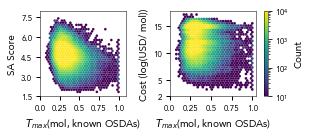

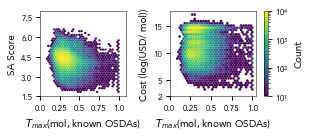

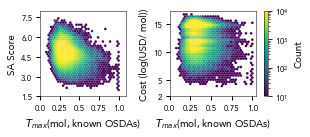

In [25]:
tick_fs = 8 # fontsize
label_fs = 10
lw = 0.5 # linewidth
wspace = 0.5
pad = 0.03
cb_ticks = [1e1, 1e2, 1e3, 1e4]
figsize = np.array([12, 4]) * cm

sa_score_limits = dict(x=(0.0, 1.1), y=(1.5, 8))
sa_score_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
sa_score_yticks = [1.5, 3, 4.5, 6, 7.5, ]

cost_limits=None
cost_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
cost_yticks = [2, 5, 10, 15,]

for charge in ["all", "mono", "diq"]:
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(wspace=wspace)
    kwargs = dict(mincnt=1, cmap='viridis', gridsize=30, vmin=10, vmax=10000, norm=LogNorm(), rasterized=True, linewidth=0.0)

    #  sa score
    if charge != "all":
        x = hyp_dfs[charge]['max_sim_to_lit']
        y = hyp_dfs[charge]['sa_score']
    else:
        x = hyp_dfs['mono']['max_sim_to_lit'].append(hyp_dfs['diq']['max_sim_to_lit'])
        y = hyp_dfs['mono']['sa_score'].append(hyp_dfs['diq']['sa_score'])
    sc = axs[0].hexbin(x, y, **kwargs)
    axs[0] = format_axs(axs[0], tick_fs, tick_fs, lw, "$T_{max}$(mol, known OSDAs)", "SA Score", label_fs, label_fs, sa_score_limits, xticks=sa_score_xticks, yticks=sa_score_yticks)

    #  cost 
    if charge != "all":
        x = hyp_dfs[charge]['max_sim_to_lit']
        y = hyp_dfs[charge]['cost_mol']
    else:
        x = hyp_dfs['mono']['max_sim_to_lit'].append(hyp_dfs['diq']['max_sim_to_lit'])
        y = hyp_dfs['mono']['cost_mol'].append(hyp_dfs['diq']['cost_mol'])
    y = np.log(y)
    sc = axs[1].hexbin(x, y, **kwargs)
    axs[1] = format_axs(axs[1], tick_fs, tick_fs, lw, "$T_{max}$(mol, known OSDAs)", "Cost (log(USD/ mol))", label_fs, label_fs, cost_limits, xticks=cost_xticks, yticks=cost_yticks)

    # add color bar to figure 
    cb = fig.colorbar(sc, ax=axs.ravel().tolist(), orientation='vertical', pad=pad)
    cb.set_label('Count', size=label_fs)
    cb.ax.tick_params(labelsize=tick_fs)
    cb.outline.set_linewidth(lw)
    cb.set_ticks(cb_ticks)

    save_mpl_fig(fig, main_op_dir + f"/{charge}_hexbins", ".pdf")
    save_mpl_fig(fig, main_op_dir + f"/{charge}_hexbins", ".svg")

In [ ]:
# Maximum Tanimoto similarity statistics 
print(
    "Minimum max Tanimoto similarity to literature OSDAs:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['max_sim_to_lit'].min(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['max_sim_to_lit'].min(), 5),

    "\nAverage max Tanimoto similarity to literature OSDAs:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['max_sim_to_lit'].mean(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['max_sim_to_lit'].mean(), 5),

    "\nMaximum max Tanimoto similarity to literature OSDAs:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['max_sim_to_lit'].max(), 5),
    "\nDiquaternary:", round(hyp_dfs['diq']['max_sim_to_lit'].max(), 5)
)

# SA score statistics
print(
    "\n\nMinimum SA score:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['sa_score'].min(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['sa_score'].min(), 5),

    "\nAverage SA score:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['sa_score'].mean(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['sa_score'].mean(), 5),

    "\nMaximum SA score:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['sa_score'].max(), 5),
    "\nDiquaternary:", round(hyp_dfs['diq']['sa_score'].max(), 5)
)

# Cost statistics
print(
    "\n\nMinimum cost/ mol:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['cost_mol'].min(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['cost_mol'].min(), 5),

    "\nAverage cost/ mol:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['cost_mol'].mean(), 5), 
    "\nDiquaternary:", round(hyp_dfs['diq']['cost_mol'].mean(), 5),

    "\nMaximum cost/ mol:",
    "\nMonoquaternary:", round(hyp_dfs['mono']['cost_mol'].max(), 5),
    "\nDiquaternary:", round(hyp_dfs['diq']['cost_mol'].max(), 5)
)

Minimum max Tanimoto similarity to literature OSDAs: 
Monoquaternary: 0.09091 
Diquaternary: 0.08 
Average max Tanimoto similarity to literature OSDAs: 
Monoquaternary: 0.32825 
Diquaternary: 0.32711 
Maximum max Tanimoto similarity to literature OSDAs: 
Monoquaternary: 1.0 
Diquaternary: 1.0


Minimum SA score: 
Monoquaternary: 1.84302 
Diquaternary: 1.98978 
Average SA score: 
Monoquaternary: 4.32591 
Diquaternary: 4.87638 
Maximum SA score: 
Monoquaternary: 6.59182 
Diquaternary: 7.42194


Minimum cost/ mol: 
Monoquaternary: 26.61853 
Diquaternary: 48.05537 
Average cost/ mol: 
Monoquaternary: 821354.4355 
Diquaternary: 1728992.47608 
Maximum cost/ mol: 
Monoquaternary: 24389576.43942 
Diquaternary: 19617301.69144


## Cheap, novel molecules
- We find the cheapest molecules that have a maximum Tanimoto similarity to literature OSDAs of 0.55.
- Molecules containing aromatic nitrogens and other unstable structures are removed.

In [26]:
cheap_novel_mono = hyp_dfs['mono'][
    (hyp_dfs['mono'].cost_mol < 200)
    & (hyp_dfs['mono'].max_sim_to_lit < 0.55)
    & (hyp_dfs['mono'].has_aromatic_n == 0)
].sort_values(['cost_mol', 'max_sim_to_lit']) 

print("Number of cheap, novel monoquaternary molecules:", cheap_novel_mono.shape[0])

# deduplicate stereoisomers 
cheap_novel_mono["nonisomeric_inchikey"] = cheap_novel_mono["inchikey"].apply(lambda x: x.split('-')[0])
cheap_novel_mono = cheap_novel_mono.drop_duplicates(subset="nonisomeric_inchikey")
cheap_novel_mono["nonisomeric_smiles"] = cheap_novel_mono.index.map(remove_stereoisomerism)

print("Number of cheap, novel monoquaternary molecules (isomer deduplicated):", cheap_novel_mono.shape[0])

with open(main_op_dir + "/cheap_novel_mono_smiles.txt", "w") as f:
    for s in cheap_novel_mono.nonisomeric_smiles:
        f.write(f'{s}\n')

Number of cheap, novel monoquaternary molecules: 344
Number of cheap, novel monoquaternary molecules (isomer deduplicated): 309


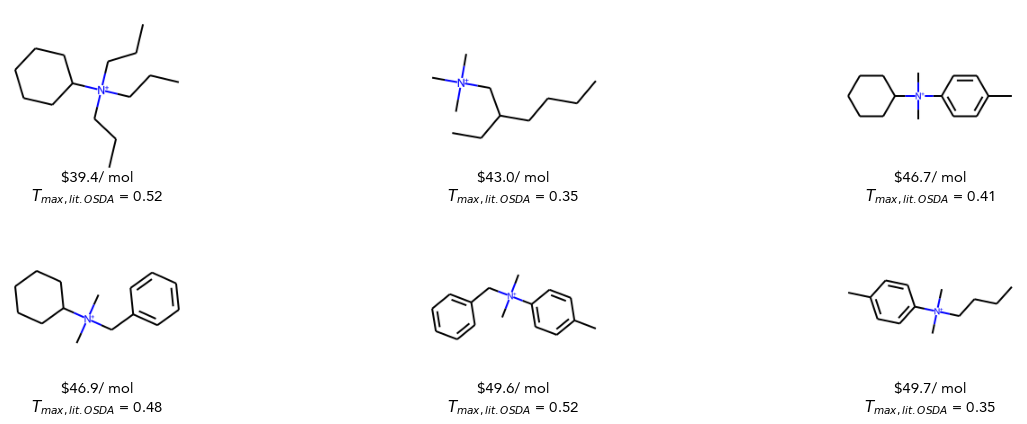

In [27]:
ll = [f"${round(p,1)}/ mol\n"+"$T_{max,lit. OSDA}$"+f" = {round(t,2)}" for p, t in zip(cheap_novel_mono.cost_mol, cheap_novel_mono.max_sim_to_lit)]
plot_mols(cheap_novel_mono.nonisomeric_smiles[:6], legend=ll, n_cols=3);

In [28]:
cheap_novel_diq = hyp_dfs['diq'][
    (hyp_dfs['diq'].cost_mol < 200)
    & (hyp_dfs['diq'].max_sim_to_lit < 0.55)
    & (hyp_dfs['diq'].has_aromatic_n == 0)
    & (~hyp_dfs['diq'].scaffold.isin(["C1=C[NH2+]C=[NH+]1", 'C1=C[N+](C2CCCCC2)(C2CCCCC2)C=[N+]1C1CCCCC1'])) # unstable structures
].sort_values(['cost_mol', 'max_sim_to_lit']) 

print("Number of cheap, novel diquaternary molecules:", cheap_novel_diq.shape[0])

# deduplicate stereoisomers 
cheap_novel_diq["nonisomeric_inchikey"] = cheap_novel_diq["inchikey"].apply(lambda x: x.split('-')[0])
cheap_novel_diq = cheap_novel_diq.drop_duplicates(subset="nonisomeric_inchikey")
cheap_novel_diq["nonisomeric_smiles"] = cheap_novel_diq.index.map(remove_stereoisomerism)

print("Number of cheap, novel diquaternary molecules (isomers deduplicated):", cheap_novel_diq.shape[0])

with open(main_op_dir + "/cheap_novel_diq_smiles.txt", "w") as f:
    for s in cheap_novel_diq.nonisomeric_smiles:
        f.write(f'{s}\n')

Number of cheap, novel diquaternary molecules: 109
Number of cheap, novel diquaternary molecules (isomers deduplicated): 58


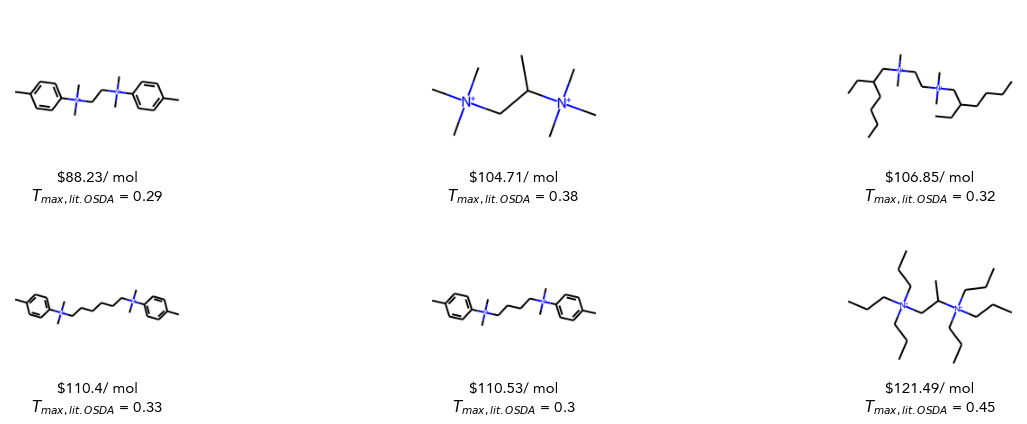

In [29]:
ll = [f"${round(p,2)}/ mol\n"+"$T_{max,lit. OSDA}$"+f" = {round(t,2)}" for p, t in zip(cheap_novel_diq.cost_mol, cheap_novel_diq.max_sim_to_lit)]
plot_mols(cheap_novel_diq.nonisomeric_smiles[:6], legend=ll, n_cols=3);

## Common scaffolds
- hypothetical monoquaternary molecules
- hypothetical diquaternary molecules
- literature OSDAs
- project molecules

In [46]:
# hypothetical monoquaternary molecules
hyp_dfs['mono']['nonisomeric_ik'] = hyp_dfs['mono'].inchikey.apply(lambda x: x.split('-')[0])
hyp_df_mono_noiso = hyp_dfs['mono'].drop_duplicates(subset='nonisomeric_ik')
hyp_df_mono_noiso.shape, hyp_dfs['mono'].shape

((172988, 35), (541558, 35))

In [60]:
common_mono_scaffolds_noiso = Counter(hyp_df_mono_noiso['scaffold']).most_common()
common_mono_scaffolds_noiso = pd.DataFrame(common_mono_scaffolds_noiso, columns=['scaffold', 'count'])

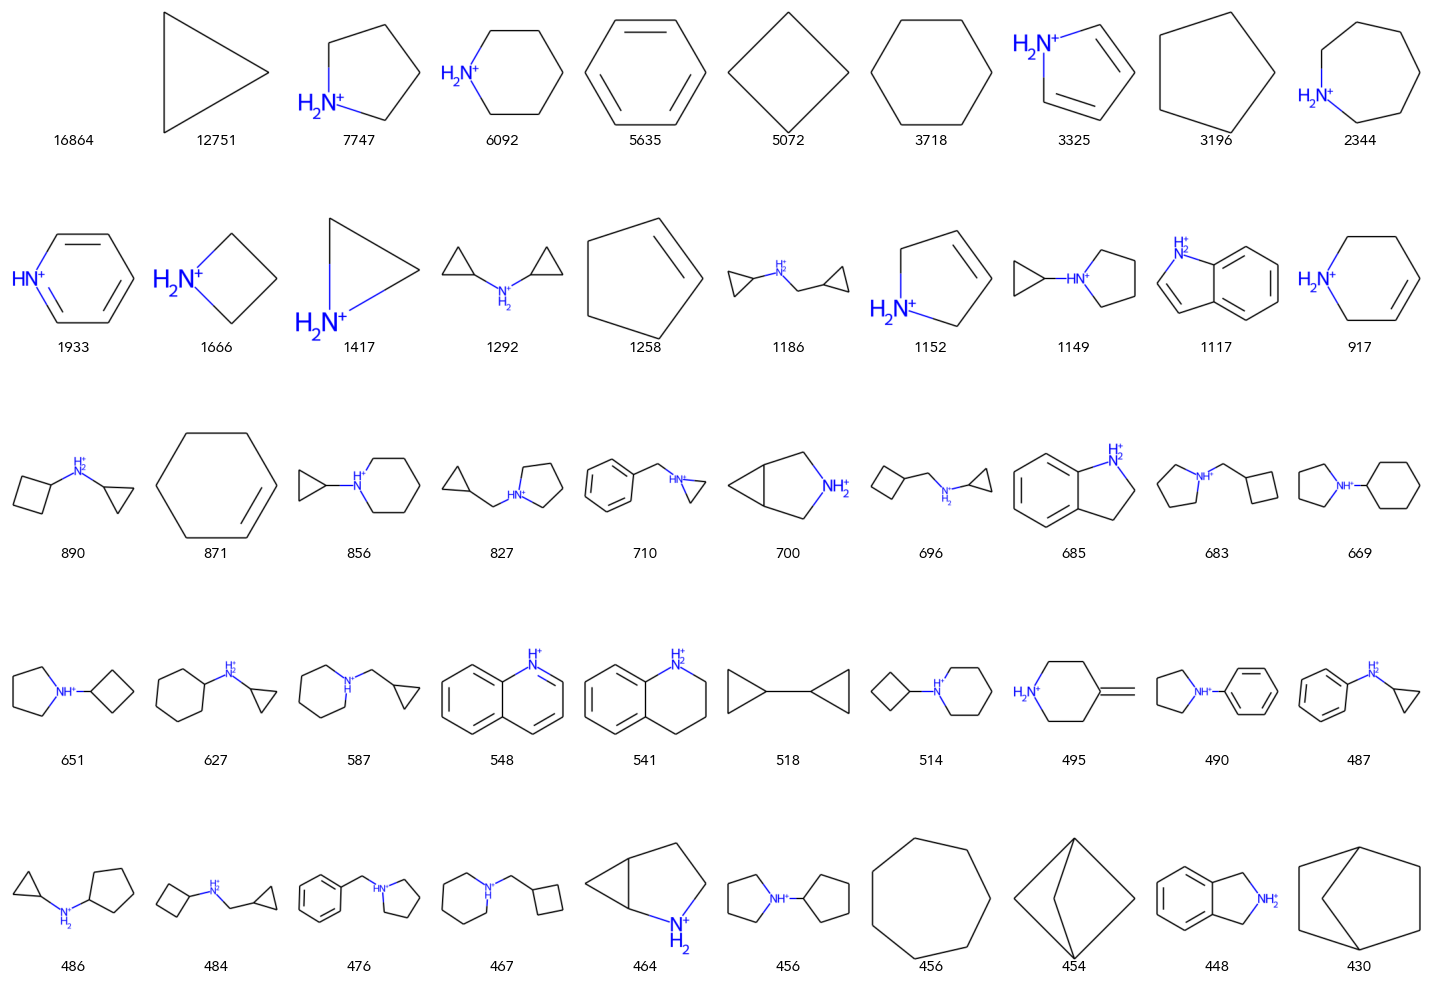

In [48]:
plot_mols(common_mono_scaffolds_noiso.scaffold[:50], legend=[str(x) for x in common_mono_scaffolds_noiso['count'][:50]], n_cols=10);

In [49]:
# hypothetical diquaternary molecules
hyp_dfs['diq']['nonisomeric_ik'] = hyp_dfs['diq'].inchikey.apply(lambda x: x.split('-')[0])
hyp_df_diq_noiso = hyp_dfs['diq'].drop_duplicates(subset='nonisomeric_ik')
hyp_df_diq_noiso.shape, hyp_dfs['diq'].shape

((366798, 35), (1587850, 35))

In [50]:
common_diq_scaffolds_noiso = Counter(hyp_df_diq_noiso.scaffold).most_common()
common_diq_scaffolds_noiso = pd.DataFrame(common_diq_scaffolds_noiso, columns=['scaffold', 'count'])

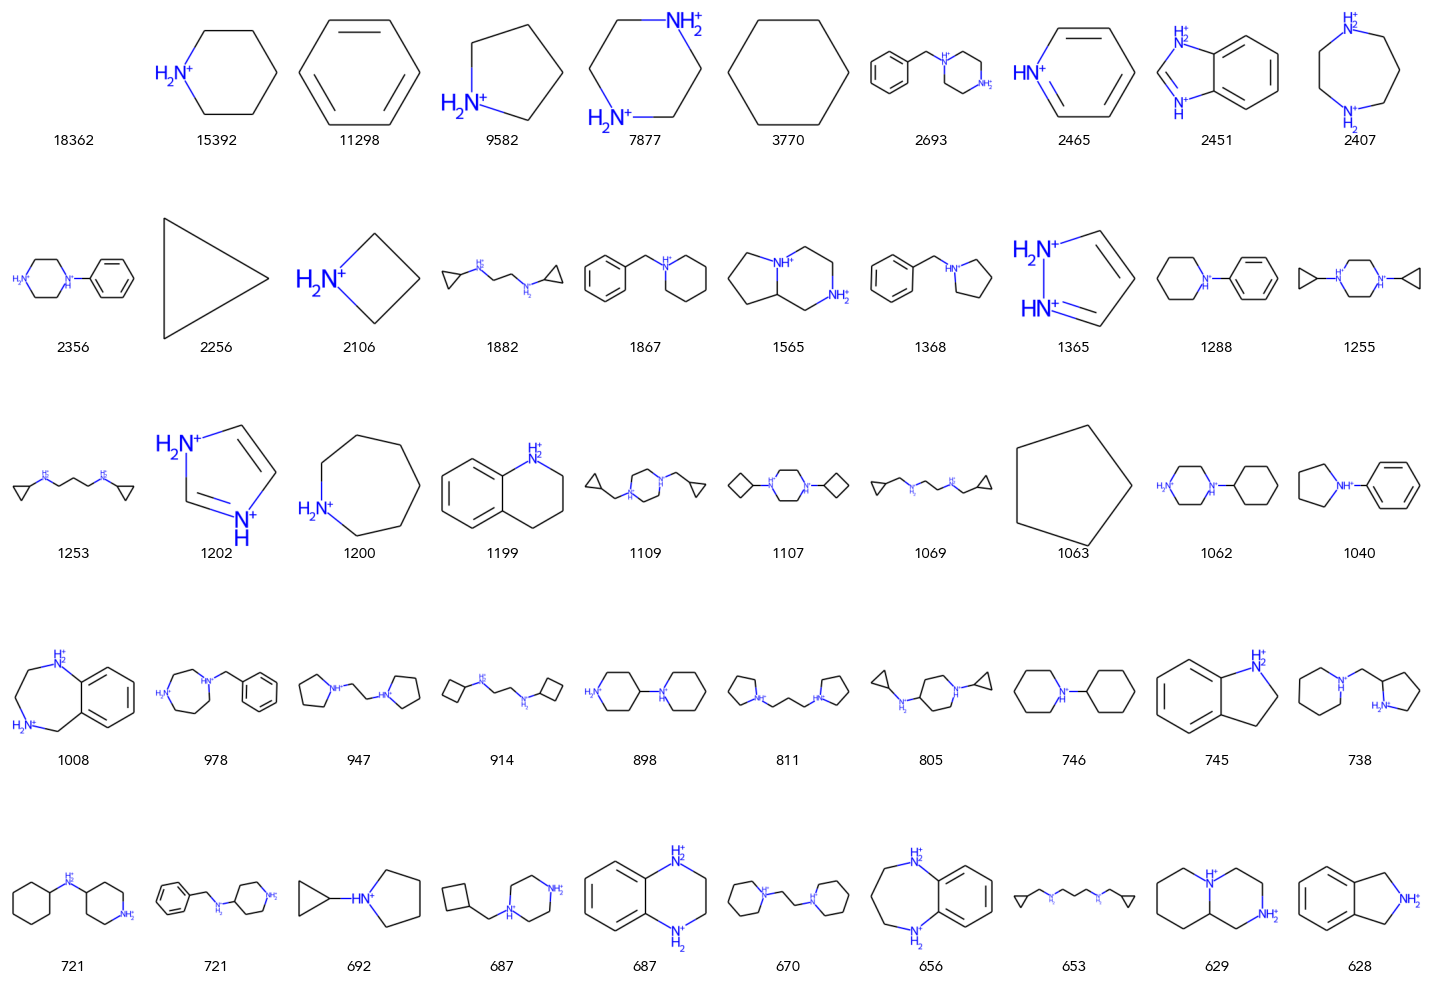

In [52]:
plot_mols(common_diq_scaffolds_noiso.scaffold[:50], legend=[str(x) for x in common_diq_scaffolds_noiso['count'][:50]], n_cols=10);

In [53]:
# Literature OSDAs
lit_ds_noiso = lit_ds.drop_duplicates(subset='nonisomeric_ik')
lit_scaffolds_noiso = [get_scaffold_smis(smiles) for smiles in lit_ds_noiso['SMILES']]
lit_scaffolds_noiso = pd.DataFrame(Counter(lit_scaffolds_noiso).most_common(), columns=['scaffold', 'count'])

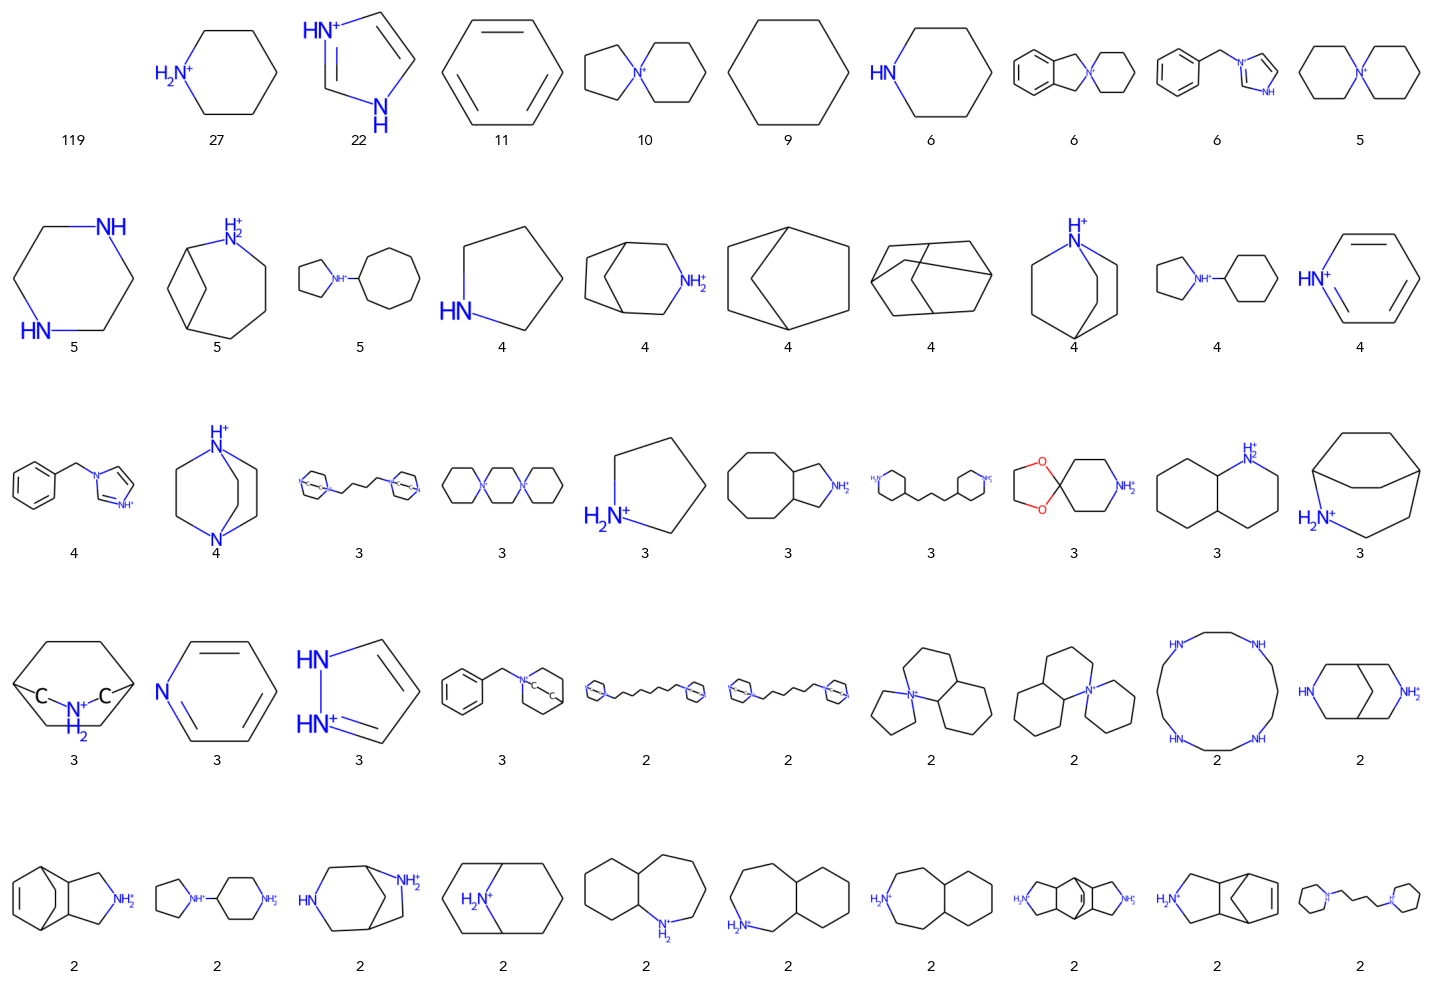

In [54]:
plot_mols(lit_scaffolds_noiso.scaffold[:50], legend=[str(x) for x in lit_scaffolds_noiso['count'][:50]], n_cols=10);